### Imports et initialisations

In [3]:
from clustertools import *

In [4]:
clusters_dir = "clusters/1M_Std_clusters/"

### Charger les clusters en mémoire

In [5]:
cc, rc, tdc = load_clusters(clusters_dir + 'km_25/')

### Analyse, affichage des informations et visualisation

In [5]:
dataset = []
for i, cluster in enumerate(cc):
    dataset += cluster
wlists = [create_sorted_wlist(cluster) for cluster in cc]

ignored = [tup[0] for tup in create_sorted_wlist(dataset)[:n_most_freq_ignored]]

mfw = most_freq_words(n_clust_info, wlists, ignored)
hkw = search_hate_words(rc, kw_file)

clust_n_msg = [(i, len(clust)) for i, clust in enumerate(cc)]

In [38]:
print_clusters_info(clust_n_msg, mfw, hkw, [])

Cluster 0 : 18539 messages
96 messages contiennent un mot-clé haineux (soit 0.52%)
Les 20 mots les plus fréquents : covid cas dos malad test vaccin, confin sanitair vaccin. masqu virus #covid19 effet mort covid-19 risqu proteg enfant vax inject 


Cluster 1 : 44877 messages
579 messages contiennent un mot-clé haineux (soit 1.29%)
Les 20 mots les plus fréquents : spac molin #spaceafrooo wsh mdrrr jsuis mdrr mec fou romain ouais ptn merd ptdrrr meuf jur mdrrrr ptdr gros dinguer 


Cluster 2 : 108306 messages
795 messages contiennent un mot-clé haineux (soit 0.73%)
Les 20 mots les plus fréquents : chos trouv genr compt demand question dis arrêt chang problem sais peux mal besoin prendr raison mieux femm cas veut 


Cluster 3 : 68760 messages
578 messages contiennent un mot-clé haineux (soit 0.84%)
Les 20 mots les plus fréquents : droit pay polit président macron mair gouvern zemmour vot appel fac social ministr peupl gauch homm journal femm soutien national 


Cluster 4 : 2262 messages
3 

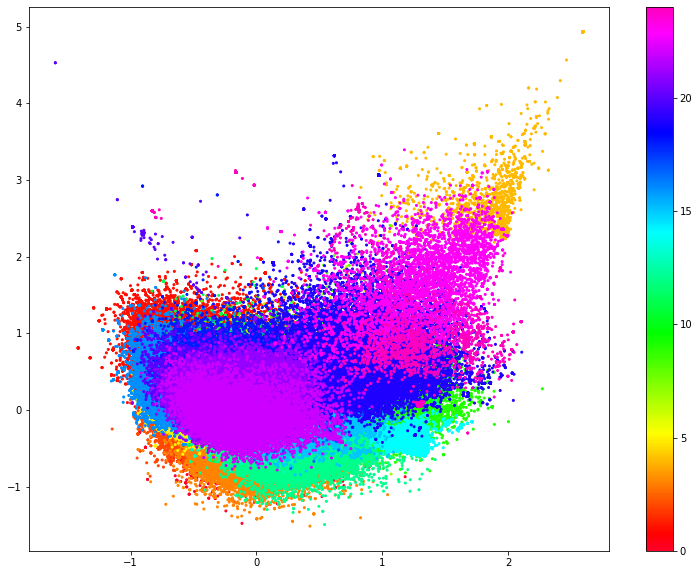

In [37]:
plot_clusters(tdc)

### Ou plus rapidement :

Cluster 0 : 18539 messages
96 messages contiennent un mot-clé haineux (soit 0.52%)
Les 20 mots les plus fréquents : covid cas dos malad test vaccin, confin sanitair vaccin. masqu virus #covid19 effet mort covid-19 risqu proteg enfant vax inject 


Cluster 1 : 44877 messages
579 messages contiennent un mot-clé haineux (soit 1.29%)
Les 20 mots les plus fréquents : spac molin #spaceafrooo wsh mdrrr jsuis mdrr mec fou romain ouais ptn merd ptdrrr meuf jur mdrrrr ptdr gros dinguer 


Cluster 2 : 108306 messages
795 messages contiennent un mot-clé haineux (soit 0.73%)
Les 20 mots les plus fréquents : chos trouv genr compt demand question dis arrêt chang problem sais peux mal besoin prendr raison mieux femm cas veut 


Cluster 3 : 68760 messages
578 messages contiennent un mot-clé haineux (soit 0.84%)
Les 20 mots les plus fréquents : droit pay polit président macron mair gouvern zemmour vot appel fac social ministr peupl gauch homm journal femm soutien national 


Cluster 4 : 2262 messages
3 

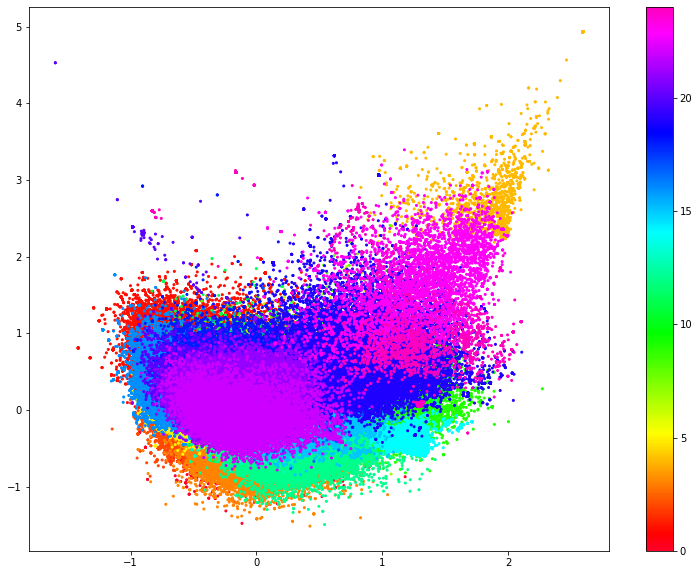

In [42]:
parse_clusters(cc, rc, tdc)